In [1]:
# Downgrade to a lower version of transformers to overcome the error
# TensorFlow and JAX classes are deprecated and
# will be removed in Transformers v5.
# We recommend migrating to PyTorch classes
# or pinning your version of Transformers.
# https://github.com/huggingface/transformers/issues/40028
# https://www.linkedin.com/pulse/hugging-face-drops-support-tensorflow-jax-revendra-t-ph-d-cppec/
# transformers<=4.54.1
!pip install transformers==4.54.1

# Does not work
# # https://stackoverflow.com/questions/78101520/valuerror-exception-encountered-when-calling-tf-distil-bert-model
# !pip uninstall -q transformers
# !pip uninstall -q sentence-transformers
# !pip install -q transformers==4.17

[RIGHT GPU](https://drlee.io/choosing-the-right-colab-runtime-a-guide-for-data-scientists-and-analysts-57ee7b7c9638)

In [2]:
import transformers

print(transformers.__version__)

4.54.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import warnings
warnings.filterwarnings("ignore")
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Input,Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Bidirectional

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Distilbert Model**

In [5]:
data = pd.read_csv("/content/data/final_filtered_annotated_reviews.csv")

In [6]:
data.shape

(13594, 2)

In [7]:
data.columns

Index(['the_review', 'topics'], dtype='object')

In [8]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


### **Data Preprocessing**

The uncased version of distilbert does not need any form of preprocessing.

In [9]:
model_data = data.copy()

In [10]:
model_data.sample(2,random_state=42)

,the_review,topics
1061,"It is a nice mouse, and I liked that it came w...",mouse
3881,Worth it,headphone


In [11]:
topics = model_data.topics.unique().tolist()
topics_mappings = {}
for index,value in enumerate(topics):
    topics_mappings[value]=index
topics_mappings

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

In [12]:
model_data['topic_label'] = model_data.topics.map(topics_mappings)

In [13]:
model_data.head()

,the_review,topics,topic_label
0,I wish I would have gotten one earlier. I love...,mouse,0
1,It is so slow and lags find a better option,mouse,0
2,Beautifully produced and lovely to look at for...,mouse,0
3,I don't typically write reviews but I keep hav...,mouse,0
4,"I bought this in late June, it looks cool with...",mouse,0


### **Downloading the Model**

In [14]:
from transformers import DistilBertTokenizer, TFDistilBertModel

In [15]:
# https://huggingface.co/distilbert/distilbert-base-uncased
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_uncased_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

In [16]:
distil_uncased_model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.54.1",
  "vocab_size": 30522
}

In [17]:
distil_uncased_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# https://huggingface.co/docs/transformers/v4.26.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus
# How tokenisation works
tokens = tokenizer.encode_plus(
    model_data.the_review[0],
    max_length=285,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [19]:
tokens.input_ids

<tf.Tensor: shape=(1, 285), dtype=int32, numpy=
array([[  101,  1045,  4299,  1045,  2052,  2031,  5407,  2028,  3041,
         1012,  1045,  2293,  2009,  1998,  2009,  3084,  2551,  1999,
         2026, 12191,  2061,  2172,  6082,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [20]:
list(tokens.keys())

['input_ids', 'attention_mask']

In [21]:
tokens.attention_mask

<tf.Tensor: shape=(1, 285), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
tokens.input_ids.shape

TensorShape([1, 285])

In [23]:
tokens.attention_mask.shape

TensorShape([1, 285])

### **Model Training & Metrics**

In [24]:
# from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,\
ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline

# To be able to plot AUC_ROC curve
from sklearn.preprocessing import label_binarize

In [25]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

In [26]:
y = model_data.topic_label

In [27]:
bin_classes = 3
y_binarize = label_binarize(y, classes=[0,1,2])

num_classes = y_binarize.shape[1]

In [28]:
X = model_data[["the_review"]]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binarize,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y_binarize)

**Define custom callbacks**

In [30]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
     super(MyCustomCallback,self).__init__()

  def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_loss = logs.get("val_loss")
            loss = logs.get('loss')
            val_acc = logs.get('val_accuracy')
            acc = logs.get('accuracy')
            if val_loss < 0.2:
              print(f"\nValidation loss is less than 0.2. \nStopping training.\n")
              self.model.stop_training = True
            elif (val_acc >= 0.85 ) and (val_loss <= 0.2 ):
                print(f"\nValidation loss is <= 0.2 and val_acc >= 0.85\nStopping training.\n")
                self.model.stop_training = True

callback = MyCustomCallback()

In [31]:
# optimizer
optimize = tf.keras.optimizers.Adam(learning_rate=0.01)
# losses
loss = tf.keras.losses.categorical_crossentropy
# metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

**Text Sequencing**

In [ ]:
tf.keras.backend.clear_session()
# tf.config.run_functions_eagerly(True)

In [33]:
X_train

,the_review
681,"I got this in the mint green color, and I like..."
11570,After 7 months the JBL Charge 4 will no longer...
7384,"got these for using the mic, mic does not work..."
6628,I went through a lot of wireless keyboards but...
7911,You can't use it for consle and still be able ...
...,...
2057,Hi love it but I bought it because it changed ...
5569,This came with an c3 charging attachment but w...
2,Beautifully produced and lovely to look at for...
5016,"Like it very much! Great price, great performa..."


In [34]:
# Resample the training data
under_sampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [35]:
X_input_ids = np.zeros((len(X_train_resampled),285), dtype=int)
X_attention_mask = np.zeros((len(X_train_resampled),285), dtype=int)

In [36]:
print(X_input_ids[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
print(X_input_ids.shape)

(8964, 285)


In [38]:
print(X_attention_mask.shape)

(8964, 285)


In [39]:
for key,text in enumerate(X_train_resampled['the_review']):
  if key == 5:
    break
  else:
    print(text)

The type c extension doesn't work, so it rendered it  useless for my Mac. I am able to use it on my pc for work... just not the intended use I bought it for.. the mouse itself is great. Light, easy to use, fits perfectly in my hand, always connects and is reliable.
Great product. We use it mostly on our fire tablet and it works great!Only complaint is that there is not built in storage for the usb-c adapter.
 This mouse is lightweight.  It charges fast by a small cable which is included.  It does not take batteries. It puts on a light show of colors fun for adults or children.  This can easily be turned off by a switch on the bottom of the mouse.The mouse itself is easy to assemble.  There is a small usb plug that clips to the bottom of the mouse for storage when you are not using it.  This plugs into your computers usb port when you do use it.This is a great mouse to use as a backup.  The color is great also.Review title:  Great spare mouse
I'm a sucker for colors and needed a new key

In [40]:
def generate_ids_masks(input_ids,attention_masks,\
                       X, tokenizer=tokenizer):
  for key, text in enumerate(X):
      tokenized_text = tokenizer.encode_plus(
                                text,
                                max_length=285,
                                truncation=True,
                                padding='max_length',
                                add_special_tokens=True,
                                return_tensors='tf'
                            )
      input_ids[key,:] = tokenized_text.input_ids
      attention_masks[key,:] = tokenized_text.attention_mask
  return input_ids,attention_masks

In [41]:
X_input_ids,X_attention_mask = generate_ids_masks(X_input_ids,X_attention_mask,X_train_resampled['the_review'])

In [42]:
print(X_input_ids)

[[ 101 1996 2828 ...    0    0    0]
 [ 101 2307 4031 ...    0    0    0]
 [ 101 2023 8000 ...    0    0    0]
 ...
 [ 101 2307 9019 ...    0    0    0]
 [ 101 3819 2005 ...    0    0    0]
 [ 101 3728 1045 ...    0    0    0]]


In [43]:
X_input_ids[0].dtype

dtype('int64')

In [44]:
print(X_attention_mask)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [45]:
print(X_input_ids.shape)

(8964, 285)


In [46]:
X_train_resampled.iloc[0].values

array(["The type c extension doesn't work, so it rendered it  useless for my Mac. I am able to use it on my pc for work... just not the intended use I bought it for.. the mouse itself is great. Light, easy to use, fits perfectly in my hand, always connects and is reliable."],
      dtype=object)

In [47]:
print(X_input_ids[0])

[  101  1996  2828  1039  5331  2987  1005  1056  2147  1010  2061  2009
 10155  2009 11809  2005  2026  6097  1012  1045  2572  2583  2000  2224
  2009  2006  2026  7473  2005  2147  1012  1012  1012  2074  2025  1996
  3832  2224  1045  4149  2009  2005  1012  1012  1996  8000  2993  2003
  2307  1012  2422  1010  3733  2000  2224  1010 16142  6669  1999  2026
  2192  1010  2467  8539  1998  2003 10539  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [48]:
print(X_attention_mask.shape)

(8964, 285)


In [49]:
print(X_attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [50]:
# Define the Intermediate layers here using
# functional approach and wrap it in a function
def intermediate_layers(distil_bert_layer):
  x = distil_bert_layer
  x = Dense(512,activation="relu",name="intermediate_layer1")(x)
  x = Dropout(0.2,name="Dropout-1")(x)
  x = Dense(256,activation="relu",name="intermediate_layer2")(x)
  x = Dropout(0.2,name="Dropout-2")(x)

  return x

In [51]:
# DistilBERT outputs a tuple where the first element at index 0
# represents the hidden-state at the output of the model's last layer.
# https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379/

In [52]:
def full_model(distilbert_base_model):
  input_ids = Input(shape=(285,), name="input_ids", dtype="int32")
  attentions = Input(shape=(285,), name="attention_mask", dtype="int32")

  # freeze the ditil_bert layers
  for layer in distilbert_base_model.layers:
    layer.trainable = False

  # Wrap the TFDistilBertModel call in a Lambda layer to handle symbolic inputs
  # This helps circumvent the strict internal type check in transformers
  def distilbert_wrapper(inputs):
    # inputs will be a list [input_ids, attention_mask] from the Lambda layer
    input_ids_tensor, attention_mask_tensor = inputs
    # TFDistilBertModel returns (last_hidden_state,) when return_dict=False
    # We need to take the first element [0] for last_hidden_state
    # Then extract the [CLS] token's hidden state (at index 0 in the sequence) as the pooled output
    last_hidden_state = distilbert_base_model(input_ids_tensor, attention_mask=attention_mask_tensor, return_dict=False)[0]
    pooled_output = last_hidden_state[:, 0, :] # Extract the CLS token's representation
    return pooled_output

  # Specify output_shape for the Lambda layer (it's the hidden_dim of DistilBERT)
  distil_bert_embeddings = tf.keras.layers.Lambda(distilbert_wrapper, output_shape=(distilbert_base_model.config.dim,), name='distilbert_output')([input_ids, attentions])

  hidden_layer = intermediate_layers(distil_bert_embeddings)
  output_layer = Dense(3, activation='softmax', name="Output-Layer")(hidden_layer)
  model = Model(inputs=[input_ids,attentions], outputs=output_layer)
  model.compile(
    optimizer=optimize,
    loss=loss,
    metrics=['accuracy',precision,recall]
)
  return model

In [53]:
main_model = full_model(distil_uncased_model)
main_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 285)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 285)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distilbert_output   │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intermediate_layer1 │ (None, 512)       │    393,728 │ distilbert_outpu… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout-1 (Dropout) │ (None, 512)       │          0 │ intermediate_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intermediate_layer2 │ (None, 256)       │    131,328 │ Dropout-1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout-2 (Dropout) │ (None, 256)       │          0 │ intermediate_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output-Layer        │ (None, 3)         │        771 │ Dropout-2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 525,827 (2.01 MB)

 Trainable params: 525,827 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
import time
start = time.time()
# # Model training
model_history = main_model.fit(
                          [X_input_ids,X_attention_mask],
                          y_train_resampled,
                          validation_split=0.2,
                          epochs=100,
                          batch_size=128,
                          verbose=1,
                          callbacks=[
                                    callback,
                                    ])
end = time.time()
print(f" Training time: {end-start} in seconds")

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - accuracy: 0.6057 - loss: 1.6655 - precision: 0.6490 - recall: 0.5169 - val_accuracy: 0.5873 - val_loss: 0.9020 - val_precision: 0.6134 - val_recall: 0.5460
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 478ms/step - accuracy: 0.8099 - loss: 0.4858 - precision: 0.8272 - recall: 0.7800 - val_accuracy: 0.5220 - val_loss: 1.0940 - val_precision: 0.5508 - val_recall: 0.4835
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.8271 - loss: 0.4649 - precision: 0.8476 - recall: 0.7998 - val_accuracy: 0.4808 - val_loss: 0.9592 - val_precision: 0.4855 - val_recall: 0.4467
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 475ms/step - accuracy: 0.8208 - loss: 0.4489 - precision: 0.8432 - recall: 0.7980 - val_accuracy: 0.4886 - val_loss: 1.1218 - val_precision: 0.4937 - val_recall: 0.4596
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.8190 - loss: 0.4630 - precision: 0.8382 - recall: 0.7931 - val_accuracy: 0.6631 - va

In [55]:
full_seconds = end - start
def convert_from_seconds(seconds):
  hours = int(seconds // 3600)
  minutes = int((seconds % 3600) // 60)
  seconds = int(seconds % 60)
  print(f"{hours} hours {minutes} minutes {seconds} seconds")
convert_from_seconds(full_seconds)

0 hours 45 minutes 19 seconds


In [56]:
y_pred_train = main_model.predict([X_input_ids, X_attention_mask])

281/281 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step


In [57]:
y_train_resampled_true = np.argmax(y_train_resampled, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

In [58]:
y_train_resampled_true

array([0, 0, 0, ..., 2, 2, 2])

In [59]:
y_pred_train

array([0, 0, 0, ..., 1, 1, 0])

In [61]:
y_train_resampled_true

array([0, 0, 0, ..., 2, 2, 2])

In [62]:
# Classification report train data
sns.set_theme(style="white")
def class_report(model_name,data,y_true,y_predict):
    print(classification_report(y_true,y_predict))
    cm = confusion_matrix(y_true,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    plt.savefig(f"/content/img/{data}_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2988
           1       0.75      0.93      0.83      2988
           2       0.98      0.55      0.70      2988

    accuracy                           0.81      8964
   macro avg       0.84      0.81      0.80      8964
weighted avg       0.84      0.81      0.80      8964



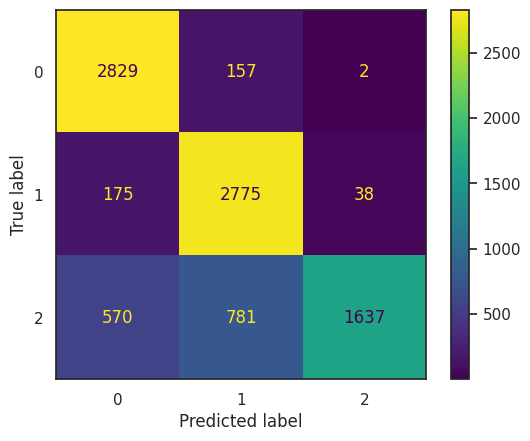

In [63]:
class_report('distilbert-base-uncased',"train_set",y_train_resampled_true,y_pred_train)

In [64]:
# https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html?highlight=roc#yellowbrick.classifier.rocauc.ROCAUC

In [65]:
# Model Performance Charts

def plot_graphs_accuracy(model:string):
  # Accuracy
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f"/content/img/{model}_accuracy.png")
  plt.show()

def plot_graphs_loss(model:string):
  # Loss
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f"/content/img/{model}_loss.png")
  plt.show()

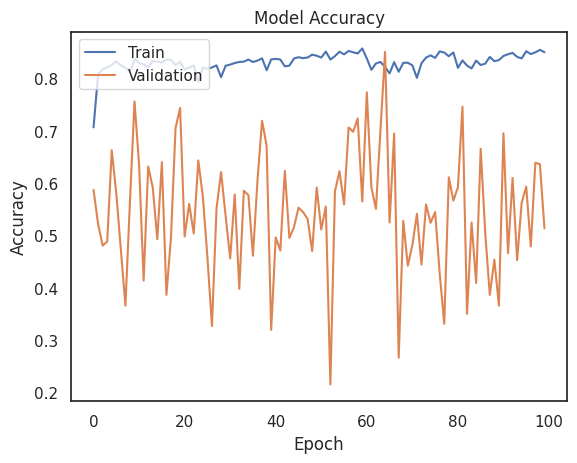

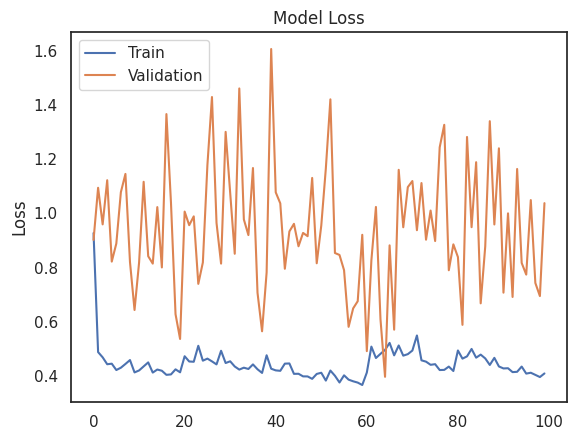

In [66]:
plot_graphs_accuracy('distilbert-base-uncased')
plot_graphs_loss('distilbert-base-uncased')

### **Plotting the ROCAUC Curve**

In [67]:
from sklearn.metrics import roc_curve,roc_auc_score, auc

fpr = {}
tpr = {}
roc_auc = {}

lw = 2

classes_by_names = ['mouse','headphone','keyboard_speakers']
# Using args
# https://www.youtube.com/watch?v=Vh__2V2tXUM
# https://www.youtube.com/watch?v=FFpDsC6B2qw
def roc_curve_plot(model_name,model,data,y_true,*args):
  X_features = []
  for feature in args:
    X_features.append(feature)

  y_pred = model.predict(X_features)
  for i in range(len(classes_by_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             lw=lw,
             label=f'ROC of class {classes_by_names[i]}, AUC = {np.round(roc_auc[i],2)}')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right", frameon=True)
  plt.savefig(f"/content/img/{model_name}_{data}_roc_curve.png")
  plt.show()
  roc_auc_scoring_macro_ovr = roc_auc_score(y_true,y_pred,
                                            multi_class="ovr",
                                            average="macro")
  print(f"AUC macro-averaged score over all classes:{np.round(roc_auc_scoring_macro_ovr,2)}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step


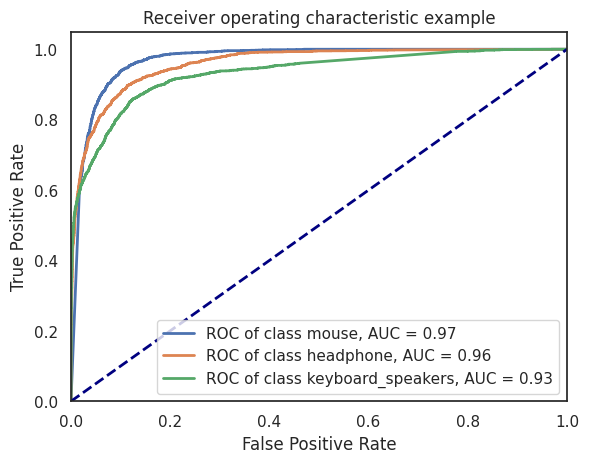

AUC macro-averaged score over all classes:0.95


In [68]:
roc_curve_plot('distilbert-base-uncased',main_model,"train_set",y_train_resampled,[X_input_ids, X_attention_mask])

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

### **Model Test & Metrics**

In [69]:
X_test_input_ids = np.zeros((len(X_test),285), dtype = 'int')
X_test_attention_mask = np.zeros((len(X_test),285),  dtype = 'int')
X_test_input_ids,X_test_attention_mask = generate_ids_masks(X_test_input_ids,X_test_attention_mask,X_test['the_review'])

In [70]:
y_pred_test = main_model.predict([X_test_input_ids,X_test_attention_mask])

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step


In [71]:
y_test_true = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1093
           1       0.72      0.91      0.80       879
           2       0.92      0.51      0.65       747

    accuracy                           0.80      2719
   macro avg       0.82      0.77      0.77      2719
weighted avg       0.82      0.80      0.79      2719



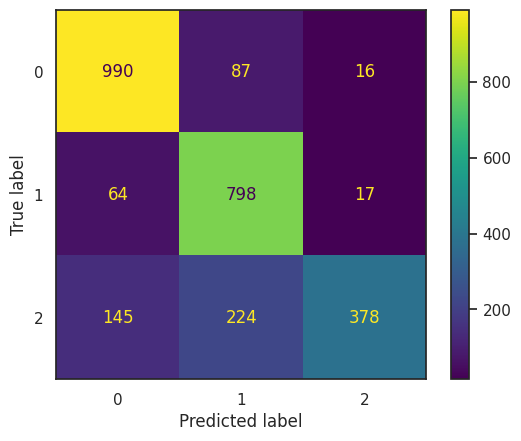

In [72]:
# Classification report test data
class_report('distilbert-base-uncased',
             "test_set",
             y_test_true,
             y_pred_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step


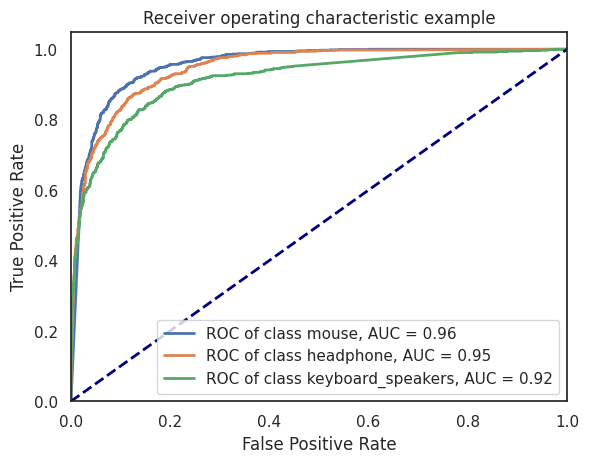

AUC macro-averaged score over all classes:0.94


In [73]:
roc_curve_plot('distilbert-base-uncased',
               main_model,
               "test_set",
               y_test,
               [X_test_input_ids,X_test_attention_mask])